In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from whitelists import *
import top_crates
import functools

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()
selected_builds = utils.load_selected_builds()

In [3]:
# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Map reasons -> number
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]

crates = pd.DataFrame({
    "crate": selected_builds.crate,
    "crate_hash": selected_builds.crate_hash,
    "package": selected_builds.package.map(lambda x: str(x).lower().replace("-", "_")),
})
user_written_unsafe_blocks = unsafe_blocks[unsafe_blocks.check_mode == "UnsafeBlockUserProvided"]
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]
unsafe_traits = traits[traits.unsafety == "Unsafe"]
unsafe_traits_impls = traits_impls[traits_impls.unsafety == "Unsafe"]

In [4]:
len(selected_builds)

304

Number of crates: 304
has_unsafe                166
has_unsafe_blocks         148
has_no_unsafe             138
has_unsafe_functions      111
has_unsafe_trait_impls     59
has_unsafe_traits          20
dtype: int64
has_unsafe                54.605263
has_unsafe_blocks         48.684211
has_no_unsafe             45.394737
has_unsafe_functions      36.513158
has_unsafe_trait_impls    19.407895
has_unsafe_traits          6.578947
dtype: float64


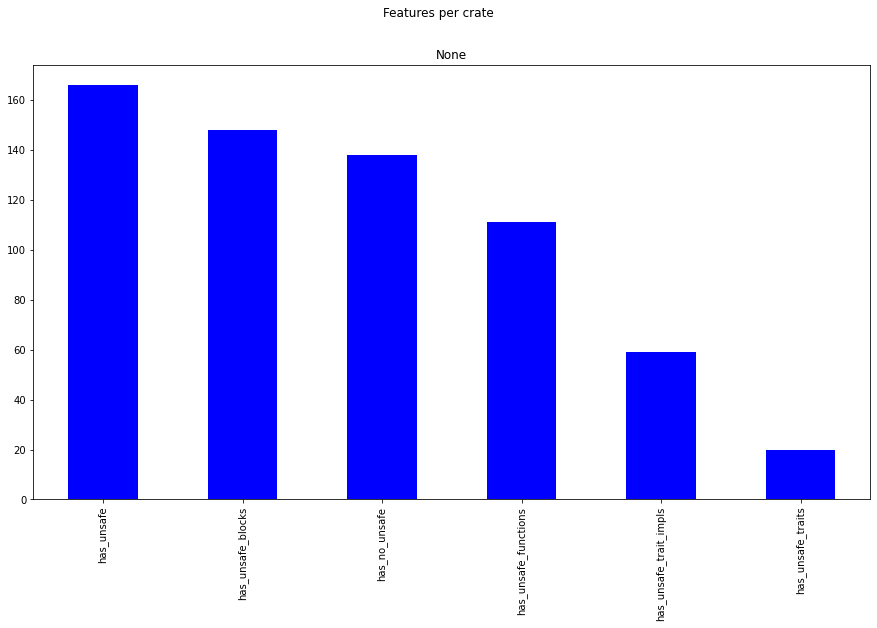

In [5]:
join_key = "crate_hash"
crates["has_unsafe_blocks"] = crates[join_key].isin(set(user_written_unsafe_blocks[join_key].unique()))
crates["has_unsafe_functions"] = crates[join_key].isin(set(unsafe_function_definitions[join_key].unique()))
crates["has_unsafe_traits"] = crates[join_key].isin(set(unsafe_traits[join_key].unique()))
crates["has_unsafe_trait_impls"] = crates[join_key].isin(set(unsafe_traits_impls[join_key].unique()))

feature_names = [
    "has_unsafe_blocks",
    "has_unsafe_functions",
    "has_unsafe_traits",
    "has_unsafe_trait_impls",
]

crates["has_unsafe"] = functools.reduce(lambda x, y: x | y, [crates[f] for f in feature_names])
feature_names.append("has_unsafe")

crates["has_no_unsafe"] = ~crates["has_unsafe"]
feature_names.append("has_no_unsafe")

print("Number of crates: {}".format(len(crates)))

feature_freq = crates[feature_names].apply(sum).sort_values(ascending=False)
feature_freq.plot.bar(subplots=True, color="blue", title="Features per crate")
print(feature_freq)
print(feature_freq / len(crates) * 100)

In [6]:
print(len(unsafe_blocks))
print(len(user_written_unsafe_blocks))
print(len(unsafe_function_definitions))
print(len(unsafe_traits))
print(len(unsafe_traits_impls))

6913
4858
4317
54
1170


ForeignItem    2746
Rust           1428
C               143
Name: abi, dtype: int64
ForeignItem    63.608988
Rust           33.078527
C               3.312486
Name: abi, dtype: float64
Unsafe function definitions: 4317


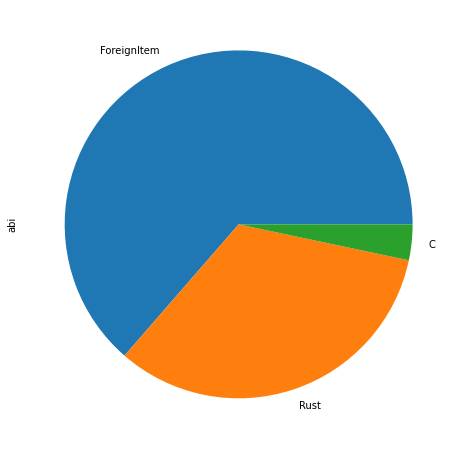

In [7]:
# Frequency of abi
values = unsafe_function_definitions.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()
del values

In [8]:
# Which crates call C functions?
c_funcs = []
for i, s in unsafe_function_definitions.iterrows():
    if 'C' in s.abi:
        c_funcs.append(s.crate)

c_funcs = list(dict.fromkeys(c_funcs))

print("Number of crates that call C functions:\t", len(c_funcs))
print("Unique crate names:")

for crate in c_funcs:
    print("\t" + crate)

Number of crates that call C functions:	 5
Unique crate names:
	openssl
	libc
	backtrace
	ring
	wasm_bindgen


In [9]:
# Which crates call foreign functions?
f_funcs = []
for i, s in unsafe_function_definitions.iterrows():
    if 'ForeignItem' in s.abi:
        f_funcs.append(s.crate)

f_funcs_unique = list(dict.fromkeys(f_funcs))

print("Number of crates that call foreign functions:\t", len(f_funcs_unique))
print("Unique crate names:")

for crate in f_funcs_unique:
    print("\t" + crate)

Number of crates that call foreign functions:	 17
Unique crate names:
	cloudabi
	openssl_sys
	time
	miniz_sys
	libgit2_sys
	libc
	libz_sys
	backtrace_sys
	curl_sys
	core_foundation_sys
	backtrace
	fuchsia_zircon_sys
	hermit_abi
	fuchsia_cprng
	libloading
	wasi
	ring


In [59]:
# SIMD const calls total
const_calls_loaded = utils.load_const_calls()
const_calls_loaded.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)
simd_functions = set([
    x
    for x in const_calls_loaded.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls_loaded[
    const_calls_loaded.def_path.isin(simd_functions)
]

# SIMD const calls unsafe only
unsafe_simd_functions = set([
    x
    for x in unsafe_block_const_calls.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
unsafe_simd_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unsafe_simd_functions)
]

# Both should be equal since can only call SIMD in unsafe blocks
#assert len(unsafe_simd_calls) == len(simd_calls)

print("Total number of SIMD calls:\t", len(simd_calls))

Total number of SIMD calls:	 0


In [11]:
# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:\n\t", simd_crates)

Number of crates that call SIMD functions:	 0
Crates that call SIMD functions:
	 []


In [12]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:\t", len(asm_fns))
if len(asm_fns) > 0:
    values = asm_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    asm_fns
    del values

Number of functions using inline assembly:	 0


In [13]:
# Whitelists
all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)
unguarded_function_names = get_unguarded_function_names(all_function_names)

all_calls = utils.load_all_calls()

unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

In [60]:
# Unchecked functions
print("unchecked_function_names:", len(unchecked_function_names))

const_unchecked_calls = const_calls_loaded[
    const_calls_loaded.def_path.isin(unchecked_function_names)
]
unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
assert(len(const_unchecked_calls) == len(unchecked_calls))

print("Calls to unchecked functions:", len(unchecked_calls))
print("Percentage:", len(unchecked_calls)/len(unsafe_calls)*100)

values = unchecked_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:",
    len(unchecked_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unchecked_function_names: 153
Calls to unchecked functions: 50
Percentage: 0.07789739355321171
Number of crates: 13
Percentage: 4.276315789473684
(http, 737a825cc02c86d0)        14
(pest, 863da43394265293)         8
(bstr, 2a87f86d1622c64a)         6
(arrayvec, f95231de97152f87)     6
(h2, 9c89f468e6495b69)           4
dtype: int64
Percentage of unsafe blocks with an unchecked function call: 0.749512816669165


In [61]:
# Unguarded functions
print("unguarded_function_names:", len(unguarded_function_names))

const_unguarded_calls = const_calls_loaded[
    const_calls_loaded.def_path.isin(unguarded_function_names)
]
unguarded_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unguarded_function_names)
]
assert(len(const_unguarded_calls) == len(unguarded_calls))

print("Calls to unguarded functions:", len(unguarded_calls))
print("Percentage:", len(unguarded_calls)/len(unsafe_calls)*100)

values = unguarded_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
print(values[:5])

print("Percentage of unsafe blocks with an unguarded function call:",
     len(unguarded_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unguarded_function_names: 0
Calls to unguarded functions: 0
Percentage: 0.0
Number of crates: 0
Percentage: 0.0
Series([], dtype: int64)
Percentage of unsafe blocks with an unguarded function call: 0.0


In [62]:
# Pointer operations (not just dereferences)
all_unsafe_function_names = set(unsafe_function_definitions.def_path.unique())
all_safe_function_names = set(function_definitions[function_definitions.unsafety == "Normal"].def_path.unique())
all_closure_names = set(function_definitions[function_definitions.unsafety == "Unknown"].def_path.unique())
assert len(all_unsafe_function_names) > 0
assert len(all_safe_function_names) > 0
assert len(all_closure_names) > 0

print("all_unsafe_function_names:", len(all_unsafe_function_names))
print("all_safe_function_names:", len(all_safe_function_names))
print("all_closure_names:", len(all_closure_names))

count1 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_unsafe_function_names)
]["pointer operation"])    # FIXME what is classified as a pointer operation?
print("unsafe functions with a pointer operation:", count1, 100 * count1 / len(all_unsafe_function_names))

count2 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_safe_function_names)
]["pointer operation"])    # FIXME what is classified as a pointer operation?
print("safe functions with a pointer operation:", count2, 100 * count2 / len(all_safe_function_names))

count3 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_closure_names)
]["pointer operation"])    # FIXME what is classified as a pointer operation?
print("closures with a pointer operation:", count3, 100 * count3 / len(all_closure_names))

all_unsafe_function_names: 4317
all_safe_function_names: 62719
all_closure_names: 6734
unsafe functions with a pointer operation: 0 0.0
safe functions with a pointer operation: 0 0.0
closures with a pointer operation: 0 0.0


In [63]:
# Count functions with pointer operations (another method)
ptr_op_fns = function_unsafe_reasons[function_unsafe_reasons["pointer operation"]]
print("Number of functions using pointer operations:", len(ptr_op_fns))
if len(ptr_op_fns) > 0:
    values = ptr_op_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with pointer operations among 10 top crates:', sum(values[:10])/len(ptr_op_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    ptr_op_fns
    del values

Number of functions using pointer operations: 0


In [65]:
# How many calls to performance-motivated intrinsic functions
blocks = const_calls_loaded[ #unsafe_block_const_calls[
    const_calls_loaded.def_path.isin(set([ #unsafe_block_const_calls.def_path.isin(set([
        'core[7bab]::intrinsics[0]::[1]::transmute[0]',
        'core[7bab]::intrinsics[0]::write_bytes[0]',
        'core[7bab]::intrinsics[0]::copy[0]',
        'core[7bab]::intrinsics[0]::copy_nonoverlapping[0]',
    ]))
][
    ["crate_callsite", "build_crate_hash", "unsafe_scope"]
].drop_duplicates()
print("blocks", len(blocks), len(unsafe_blocks), 100 * len(blocks) / len(unsafe_blocks))
print()
print("crates", len(blocks.build_crate_hash.unique()),
      100 * len(blocks.build_crate_hash.unique()) / len(selected_builds.crate_hash.unique()))
data = pd.value_counts(blocks.crate_callsite)
print(data)
print(sum(data > 3), 100 * sum(data > 3) / len(selected_builds.crate_hash.unique()))
print()
print("With 1000+ unsafe blocks:")
for crate, count in data[data >= 1000].iteritems():
    print("* {} {}: https://crates.io/crates/{}".format(count, crate, crate))
del blocks, data

blocks 0 6913 0.0

crates 0 0.0
Series([], Name: crate_callsite, dtype: int64)
0 0.0

With 1000+ unsafe blocks:


In [66]:
# How many calls to performance-motivated mem functions
blocks = const_calls_loaded[ #unsafe_block_const_calls[
    const_calls_loaded.def_path.isin(set([ #unsafe_block_const_calls.def_path.isin(set([
        'core[7bab]::mem[0]::transmute_copy[0]',
    ]))
][
    ["crate_callsite", "build_crate_hash", "unsafe_scope"]
].drop_duplicates()
print("blocks", len(blocks), len(unsafe_blocks), 100 * len(blocks) / len(unsafe_blocks))
print()
print("crates", len(blocks.build_crate_hash.unique()),
      100 * len(blocks.build_crate_hash.unique()) / len(selected_builds.crate_hash.unique()))
data = pd.value_counts(blocks.crate_callsite)
print(data)
print(sum(data > 3), 100 * sum(data > 3) / len(selected_builds.crate_hash.unique()))
print()
print("With 1000+ unsafe blocks:")
for crate, count in data[data >= 1000].iteritems():
    print("* {} {}: https://crates.io/crates/{}".format(count, crate, crate))
del blocks, data

blocks 0 6913 0.0

crates 0 0.0
Series([], Name: crate_callsite, dtype: int64)
0 0.0

With 1000+ unsafe blocks:


In [67]:
# How many calls to performance-motivated slice functions
blocks = const_calls_loaded[ #unsafe_block_const_calls[
    const_calls_loaded.def_path.isin(set([ #unsafe_block_const_calls.def_path.isin(set([
        'core[7bab]::slice[0]::from_raw_parts[0]',
        'core[7bab]::slice[0]::from_raw_parts_mut[0]',
        'core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]',
        'core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]',
    ]))
][
    ["crate_callsite", "build_crate_hash", "unsafe_scope"]
].drop_duplicates()
print("blocks", len(blocks), len(unsafe_blocks), 100 * len(blocks) / len(unsafe_blocks))
print()
print("crates", len(blocks.build_crate_hash.unique()),
      100 * len(blocks.build_crate_hash.unique()) / len(selected_builds.crate_hash.unique()))
data = pd.value_counts(blocks.crate_callsite)
print(data)
print(sum(data > 3), 100 * sum(data > 3) / len(selected_builds.crate_hash.unique()))
print()
print("With 1000+ unsafe blocks:")
for crate, count in data[data >= 1000].iteritems():
    print("* {} {}: https://crates.io/crates/{}".format(count, crate, crate))
del blocks, data

blocks 0 6913 0.0

crates 0 0.0
Series([], Name: crate_callsite, dtype: int64)
0 0.0

With 1000+ unsafe blocks:


In [68]:
# Filter by user-written unsafe code
user_written_unsafe_const_calls = const_calls_loaded[ #unsafe_block_const_calls[
    #unsafe_block_const_calls.check_mode == "UnsafeBlockUserProvided"
    const_calls_loaded.check_mode == "UnsafeBlockUserProvided"
]

# Filter by target language
user_written_unsafe_const_calls_rust = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "Rust"
]
user_written_unsafe_const_calls_fi = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "ForeignItem"
]
user_written_unsafe_const_calls_c = user_written_unsafe_const_calls[
    user_written_unsafe_const_calls.abi == "C"
]

perf_mot_unsafe_rust = set([
    x
    for x in user_written_unsafe_const_calls_rust.def_path.unique()
    if x.startswith('core[7bab]::core_arch') 
        or x.startswith('core[7bab]::intrinsics[0]::[1]::transmute[0]')
        or x.startswith('core[7bab]::intrinsics[0]::write_bytes[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy[0]')
        or x.startswith('core[7bab]::intrinsics[0]::copy_nonoverlapping[0]')
        or x.startswith('core[7bab]::mem[0]::transmute_copy[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts[0]')
        or x.startswith('core[7bab]::slice[0]::from_raw_parts_mut[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]')
        or x.startswith('core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]')
        or ("unchecked" in x)
        or ("unguarded" in x)
        or ("asm!" in x)
])

In [70]:
# Performance-motivated Rust calls from within an unsafe BLOCK
perf_mot_unsafe_rust_calls = user_written_unsafe_const_calls_rust[
    user_written_unsafe_const_calls_rust.def_path.isin(perf_mot_unsafe_rust)
]
pmu_rust_values = perf_mot_unsafe_rust_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()

# ForeignItem calls
pmu_fi_values = user_written_unsafe_const_calls_fi[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()

# C calls
pmu_c_values = user_written_unsafe_const_calls_c[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()

In [71]:
block_frames = [pmu_rust_values, pmu_fi_values, pmu_c_values]
block_values = pd.concat(block_frames)

print("Total number of performance-motivated calls:\t", len(block_values))
print("Out of total number user-written unsafe const calls:\t", len(user_written_unsafe_block_const_calls))
print("Percentage of user-written unsafe block const calls that are performance-motivated:\n\t", 
      (len(block_values) / len(user_written_unsafe_block_const_calls))*100)
print()
print("Number of crates:\t", len(block_values))
print("Percentage:\t", len(block_values)/len(selected_builds)*100)

Total number of performance-motivated calls:	 89
Out of total number user-written unsafe const calls:	 16127
Percentage of user-written unsafe block const calls that are performance-motivated:
	 0.5518695355614808

Number of crates:	 89
Percentage:	 29.276315789473685


In [72]:
# For comparison, number of crates that have an unsafe block, period
join_key = "crate_hash"
crates["has_unsafe_blocks"] = crates[join_key].isin(set(user_written_unsafe_blocks[join_key].unique()))

feature_names = [
    "has_unsafe_blocks",
]

print("Number of crates: {}".format(len(crates)))

feature_freq = crates[feature_names].apply(sum).sort_values(ascending=False)
print(feature_freq)
print(feature_freq / len(crates) * 100)

Number of crates: 304
has_unsafe_blocks    148
dtype: int64
has_unsafe_blocks    48.684211
dtype: float64


In [73]:
# Moving on to unsafe FUNCTIONS
unsafe_rust_functions = unsafe_function_definitions[
    unsafe_function_definitions.abi == "Rust"
]

In [75]:
# Not yet sure if we want to use this; maybe in the dedicated paper section but not in intro
actually_unsafe_rust_functions = unsafe_rust_functions[
    unsafe_rust_functions.uses_unsafe == True
]

print("Number of actually unsafe Rust functions:\t", len(actually_unsafe_rust_functions))

Number of actually unsafe Rust functions:	 878
